--------------------
## Scenario building of the lake level


In [1]:
# load the packages
import xarray as xr
import pandas as pd
import numpy  as np
from datetime import date
from datetime import datetime
import os
import shutil
import glob
#import datetime #import date
import matplotlib.pyplot  as plt
import matplotlib
from ipynb.fs.full.Untitled2 import save_netcdf
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 20}
# matplotlib.rcs('font', **font)
plt.rc('font', **font)


In [4]:
def shift_target_time (df, target_datetime, shifted_datetime, start_datetime, end_datetime):
    
    #
    column_names = list(df.columns)

    start_date   = start_datetime
    end_date     = end_datetime
    target_date  = target_datetime
    shifted_date = shifted_datetime

    # slice
    df_slice = df.copy()
    df_slice = df_slice.loc[start_date:end_date]
    df_slice['rank'] = np.arange(len(df_slice))
    df_slice['rank_scaled'] = np.nan
    df_slice.loc[shifted_date,'rank_scaled'] = df_slice.loc[target_date,'rank']
    df_slice.loc[start_date,'rank_scaled'] = df_slice.loc[start_date,'rank']
    df_slice.loc[end_date,'rank_scaled'] = df_slice.loc[end_date,'rank']
    df_slice['rank_scaled'] = df_slice['rank_scaled'].interpolate(method='linear')


    for column_name in column_names:
        df_slice[column_name] = np.interp(df_slice['rank_scaled'],\
                                          df_slice['rank'],\
                                          df_slice[column_name])
        df.loc[df_slice.index,column_name] = df_slice[column_name]
    
    return df


def shift_value_target_time (df, target_time, start_time, end_time, scale):
    
    #
    df_temp = df.copy()
    df_temp ['w'] = np.nan
    df_temp.loc[target_time,'w'] = 1
    df_temp.loc[:start_time,'w'] = 0
    df_temp.loc[end_time:,  'w'] = 0
    
    df_temp = df_temp.interpolate()
    
    
    for column in df.columns:
        df.loc[:,column]  = (1-df_temp.loc[:,'w']) * df.loc[:,column] + \
                             df_temp.loc[:,'w'] * (df.loc[:,column] - scale)
    
    
    return df
    
    
df = pd.read_csv('../data/HYDAT/05HF003_level.csv') # elevation record of lake diefenbaker
# set the date as the index
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')
df = df.loc['2013-06-01':'2013-07-31']


lowest_level_dates = [22,   23,  24,   25]
resume_level_dates = [22,   23,  24,   25,  26,   27,  28, 29, 30]
start_level_dates  = [15,   16,  17,   18,  19,   20,  21, 22]
level_decreases    = [ 0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5]
lowest_level_date_target = [24]


combination = np.array(np.meshgrid(start_level_dates, lowest_level_dates, resume_level_dates, level_decreases, lowest_level_date_target)).T.reshape(-1,5)

scenarios = pd.DataFrame(combination, columns = ['start_level_dates', 'lowest_level_dates',\
                                                 'resume_level_dates', 'level_decreases',\
                                                 'target_date'])
#
scenarios = scenarios[scenarios['start_level_dates'] < scenarios['lowest_level_dates']]
scenarios = scenarios[scenarios['lowest_level_dates'] < scenarios['resume_level_dates']]

#
scenarios = scenarios[scenarios['start_level_dates'] < scenarios['target_date']]
scenarios = scenarios[scenarios['target_date'] < scenarios['resume_level_dates']]


scenarios = scenarios.reset_index()

df_scenarios = df.copy()
df_org = df.copy()

for index, row in scenarios.iterrows():
    
    start_level_date = "{:.0f}".format(row.start_level_dates)
    resume_level_date = "{:.0f}".format(row.resume_level_dates)
    lowest_level_date = "{:.0f}".format(row.lowest_level_dates)
    level_decrease = row.level_decreases
    

    df = df_org.copy()
    
    
    #
    # print('Scenario: ',start_level_date, lowest_level_date, resume_level_date, level_decrease)
    
    #
    df1 = shift_target_time (df,\
                            '2013-06-24 00:00:00',\
                            '2013-06-'+str(lowest_level_date)+' 00:00:00',\
                            '2013-06-'+str(start_level_date)+' 00:00:00',\
                            '2013-06-'+str(resume_level_date)+' 00:00:00')
    
    #
    df2 = shift_value_target_time (df1,\
                                  '2013-06-'+str(lowest_level_date)+' 00:00:00',\
                                  '2013-06-'+str(start_level_date)+' 00:00:00',\
                                  '2013-06-'+str(resume_level_date)+' 00:00:00',\
                                  level_decrease)
    
    #
    column_name = 'scenario_'+str(start_level_date)+'_'+str(lowest_level_date)+'_'+str(resume_level_date)+'_'+str(level_decrease)
    df_scenarios [column_name] = df2['05HF003']

print("number of scenarios: ", len(df_scenarios.columns)-1)
df_scenarios

df_scenarios.to_csv ('../data/ensemble/Level_ensemble_Scenarios.csv')



15 25 22 0.0
15 25 23 0.0
15 25 24 0.0
16 25 22 0.0
16 25 23 0.0
16 25 24 0.0
17 25 22 0.0
17 25 23 0.0
17 25 24 0.0
18 25 22 0.0
18 25 23 0.0
18 25 24 0.0
19 25 22 0.0
19 25 23 0.0
19 25 24 0.0
20 25 22 0.0
20 25 23 0.0
20 25 24 0.0
21 25 22 0.0
21 25 23 0.0
21 25 24 0.0
22 25 23 0.0
22 25 24 0.0
15 26 22 0.0
15 26 23 0.0
15 26 24 0.0
15 26 25 0.0
16 26 22 0.0
16 26 23 0.0
16 26 24 0.0
16 26 25 0.0
17 26 22 0.0
17 26 23 0.0
17 26 24 0.0
17 26 25 0.0
18 26 22 0.0
18 26 23 0.0
18 26 24 0.0
18 26 25 0.0
19 26 22 0.0
19 26 23 0.0
19 26 24 0.0
19 26 25 0.0
20 26 22 0.0
20 26 23 0.0
20 26 24 0.0
20 26 25 0.0
21 26 22 0.0
21 26 23 0.0
21 26 24 0.0
21 26 25 0.0
22 26 23 0.0
22 26 24 0.0
22 26 25 0.0
15 27 22 0.0
15 27 23 0.0
15 27 24 0.0
15 27 25 0.0
16 27 22 0.0
16 27 23 0.0
16 27 24 0.0
16 27 25 0.0
17 27 22 0.0
17 27 23 0.0
17 27 24 0.0
17 27 25 0.0
18 27 22 0.0
18 27 23 0.0
18 27 24 0.0
18 27 25 0.0
19 27 22 0.0
19 27 23 0.0
19 27 24 0.0
19 27 25 0.0
20 27 22 0.0
20 27 23 0.0
20 27 24 0.0

17 28 24 0.75
17 28 25 0.75
18 28 22 0.75
18 28 23 0.75
18 28 24 0.75
18 28 25 0.75
19 28 22 0.75
19 28 23 0.75
19 28 24 0.75
19 28 25 0.75
20 28 22 0.75
20 28 23 0.75
20 28 24 0.75
20 28 25 0.75
21 28 22 0.75
21 28 23 0.75
21 28 24 0.75
21 28 25 0.75
22 28 23 0.75
22 28 24 0.75
22 28 25 0.75
15 29 22 0.75
15 29 23 0.75
15 29 24 0.75
15 29 25 0.75
16 29 22 0.75
16 29 23 0.75
16 29 24 0.75
16 29 25 0.75
17 29 22 0.75
17 29 23 0.75
17 29 24 0.75
17 29 25 0.75
18 29 22 0.75
18 29 23 0.75
18 29 24 0.75
18 29 25 0.75
19 29 22 0.75
19 29 23 0.75
19 29 24 0.75
19 29 25 0.75
20 29 22 0.75
20 29 23 0.75
20 29 24 0.75
20 29 25 0.75
21 29 22 0.75
21 29 23 0.75
21 29 24 0.75
21 29 25 0.75
22 29 23 0.75
22 29 24 0.75
22 29 25 0.75
15 30 22 0.75
15 30 23 0.75
15 30 24 0.75
15 30 25 0.75
16 30 22 0.75
16 30 23 0.75
16 30 24 0.75
16 30 25 0.75
17 30 22 0.75
17 30 23 0.75
17 30 24 0.75
17 30 25 0.75
18 30 22 0.75
18 30 23 0.75
18 30 24 0.75
18 30 25 0.75
19 30 22 0.75
19 30 23 0.75
19 30 24 0.75
19 30 

22 30 23 1.5
22 30 24 1.5
22 30 25 1.5
number of scenarios:  1246


-----------
## Creating the target storage from the level

                 05HF003  scenario_15_22_25_0.0  scenario_15_23_25_0.0  \
DATE                                                                     
2013-06-01  7.867204e+09           7.867204e+09           7.867204e+09   
2013-06-02  7.902327e+09           7.902327e+09           7.902327e+09   
2013-06-03  7.934040e+09           7.934040e+09           7.934040e+09   
2013-06-04  7.970292e+09           7.970292e+09           7.970292e+09   
2013-06-05  8.002373e+09           8.002373e+09           8.002373e+09   
...                  ...                    ...                    ...   
2013-07-27  9.212423e+09           9.212423e+09           9.212423e+09   
2013-07-28  9.222106e+09           9.222106e+09           9.222106e+09   
2013-07-29  9.226318e+09           9.226318e+09           9.226318e+09   
2013-07-30  9.230530e+09           9.230530e+09           9.230530e+09   
2013-07-31  9.234742e+09           9.234742e+09           9.234742e+09   

            scenario_15_24_25_0.0  sc

Text(0, 0.5, 'Storage of \n lake Diefenbaker [m3]')

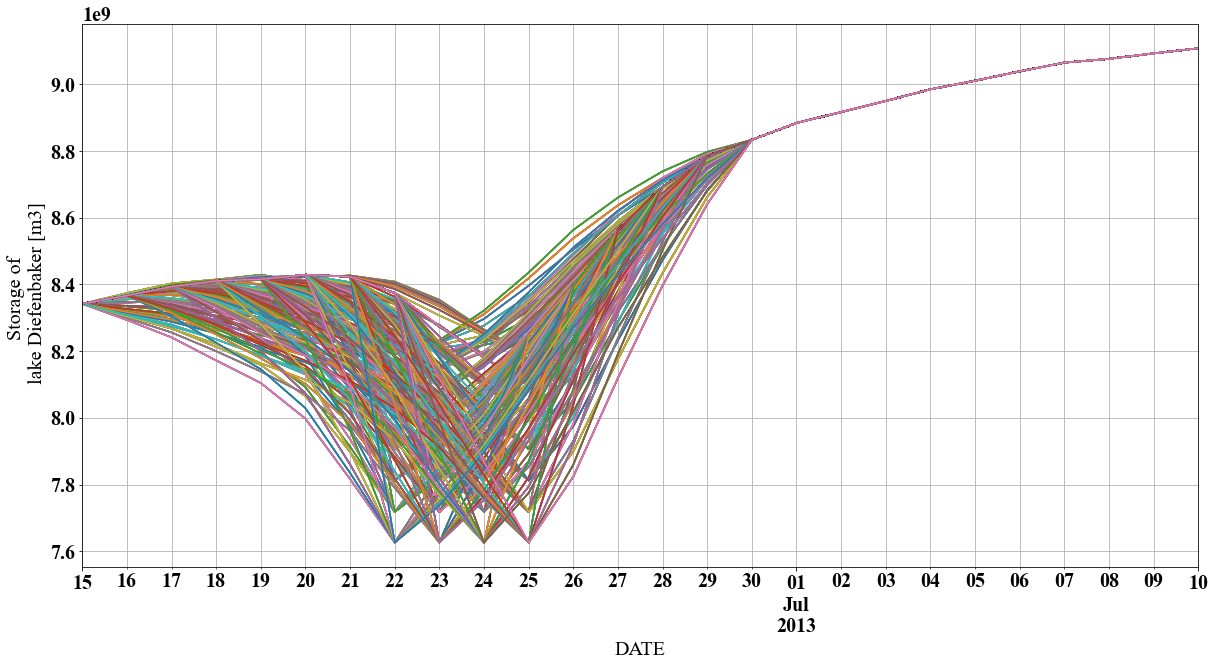

In [5]:
# load the elevation storage relationship
ele_str = pd.read_csv('../data/Elevation_Storage/Storage_Elevation_Diefenbaker.csv')

df_scenarios_storage = df_scenarios.copy()

for column in df_scenarios_storage.columns:
    df_scenarios_storage [column] =    np.interp(df_scenarios_storage [column], ele_str['Elevation(m)'], ele_str['Storage(m^3)'])

df_scenarios_storage = df_scenarios_storage.loc['2013-06-01':'2013-07-31']
df_scenarios_storage.to_csv('../data/ensemble/Storage_ensemble_Scenarios.csv')

# plotting
df_scenarios_storage['2013-06-15':'2013-07-10'].plot(figsize=(20,10))
plt.grid(which='both')
plt.gca().get_legend().remove()
plt.ylabel('Storage of \n lake Diefenbaker [m3]')

